# Welcome  

Notebook Author: Samuel Alter  
Notebook Subject: Capstone Project - Image Analysis

BrainStation Winter 2023: Data Science

This notebook is for running my satellite images through deep learning networks. The images have been pre-processed in a separate notebook.

The goal is to find a pre-trained CNN to adapt to our specific use-case of finding insights about wildfire-prone landscapes.

## Imports

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
from PIL import Image
import cv2

## Split all 7760 images in to `train` and `test` splits

In [48]:
def createTTS(start,total_img:int,train_frac:float,step=1,replace=False,verbose=True):
    '''
    Creates two lists for a train/test split of numbered files,
    such as patches previously made from a larger image 
    to be used in convolutional neural network workflows.
    
    ----
    Inputs:
    
    >start
    starting number for the image patches
    
    >total_img
    serves both as total size of images in the patch set
    
    >step
    defaults to 1, the step size in creating a list of numbers
    
    >train_frac
    the fraction of the numbers that will be split into the
    training set. Please make the number between 0 and 1
    
    >replace
    since this function is splitting the numbers, replace defaults
    to False
    
    >verbose
    runs a line of code to check that the splitting was successful
    
    ----
    Outputs:
    
    >train_test_tuple
    a tuple of two lists, containing the train and test list
    that when combined together are the same size as the 
    total_img value
    
    '''
    # create list with each image's number
    # there are 7760 images each in the fire and nofire datasets
    file_nums=np.arange(start,total_img,step)

    # create train and test splits
    trains=np.random.choice(file_nums,
                            size=(int(total_img*train_frac)),
                            replace=replace)

    tests=list(set(file_nums)-set(trains))

    if verbose==True:
        print(f'The size of train ({len(trains)}) and tests ({len(tests)}) together is {len(trains)+len(tests)}')
    
    train_test_tuple=(trains,tests)
    
    return train_test_tuple

In [60]:
# run function

train_test_tuple=createTTS(start=0,total_img=7760,train_frac=0.7,\
                           step=1,replace=False,verbose=True)
train_test_tuple

# sanity checks
trains=train_test_tuple[0]
tests=train_test_tuple[1]

print(len(trains))
print(len(tests))

print(set(trains) & set(tests))

The size of train (5432) and tests (2328) together is 7760
5432
2328
set()


In [61]:
trains

array([7712, 5187, 5428, ..., 3943, 4726, 3278])

In [151]:
# convert list of integers to list of strings
# important for moving files in next step
trains=[str(i) for i in trains]
valids=[str(i) for i in tests]

type(trains[0])

str

### Move the images to their corresponding training and validation locations

In [89]:
def copyFileByNumber(source, dest, set_):
    '''
    Copies files from `source` to `dest` that have numbers 
    in their filename and that match any element in `set_` 
    list (either trains or tests).
    
    ----
    Inputs:
    
    >source
    source of files to be copied
    
    >dest
    destination of files to be moved to
    
    >set_
    specify either the training ('trains') or 
    test ('tests') set
    
    ----
    Outputs:
    
    >N/A
    copies files, no further output
    
    '''
    
    for filename in os.listdir(source):
        # Get the number in the filename
        file_num = "".join(filter(str.isdigit, filename))
        # Check if the number is in the trains list
        if file_num in set_:
            # Copy the file to the destination folder
            shutil.copy(os.path.join(source, filename), dest)

In [112]:
def filePresenceSumChecker(directory:str,extension:str,verbose=False):
    '''
    Checks the sum of all the files with a certain extension.
    
    Useful to see if a process has already been completed.
    
    ----
    Inputs
    
    >directory
    path to a folder to check if files are there
    
    >extension
    user-specified extension to only count those files
    
    ----
    Outputs
    
    >counter
    gives the amount of files within the directory
    '''
    
    counter=0
    
    # get a list of all files in the directory
    files = os.listdir(directory)

    # iterate through the files and check if any have the specified extension
    for file in files:
        if file.endswith(extension):
            counter+=1
                
    if verbose==True:
        print(f"There are {counter} '{extension}' files within {directory}.")

    return counter

In [114]:
# setup loop for copyFileByNumber

source_train_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/patch_fire'
source_train_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/patch_nofire'
source_valid_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/patch_fire'
source_valid_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/patch_nofire'

dest_train_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/fire'
dest_train_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/nofire'
dest_valid_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/fire'
dest_valid_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/nofire'

sources = [source_train_fire,
          source_train_nofire,
          source_valid_fire,
          source_valid_nofire]

dests = [dest_train_fire,
        dest_train_nofire,
        dest_valid_fire,
        dest_valid_nofire]


for src,des in zip(sources,dests):
#     flow control
    if filePresenceSumChecker(directory=dests[0],extension='.tif')>0:
    
        copyFileByNumber(source=src,dest=des,trains=trains)

### Rename files and change to proper format

Convert filenames from `patch_fire.X.tif` to `patch_fire_X.tif`, where X is a number with one or more digits.

In [88]:
def fileRenamer(source:str, prefix:str,extension='.tif'):
    '''
    Renames files to the format provided by the user.
    It can help clean an image format to one that can be
    read by modules like Tensorflow.
    
    ----
    Inputs:
    
    >source
    the directory where the files are located
    
    >prefix
    the base part of the filename that will remain
    
    >extension
    defaults to '.tif', but this will ensure you only rename
    certain files that have the specified extension
    
    ----
    Outputs:
    
    >N/A
    renames files in-place, no further output
    '''

    # loop over each file from the source directory
    for filename in os.listdir(source):
        
        # check if the file is the provided `ext` (extension)
        if filename.endswith(extension):
            
            # split the filename into base and extension
            base, ext = os.path.splitext(filename)
            
            # split the base into the prefix and number parts
            prefix, number = base.split('.', 1)
            
            # create the new filename with the desired format
            new_filename = f'{prefix}_{number}{ext}'
            
            # rename the file
            os.rename(os.path.join(source, filename), 
                      os.path.join(source, new_filename))

In [119]:
# make a for loop to rename all the files

source_train_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/tifs_or_old/train_tif/fire'
source_train_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/tifs_or_old/train_tif/nofire'
source_valid_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/tifs_or_old/validation_tif/fire'
source_valid_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/tifs_or_old/validation_tif/nofire'

sources=[source_train_fire,
        source_train_nofire,
        source_valid_fire,
        source_valid_nofire]
 
# flow control
if filePresenceSumChecker(directory=source_train_fire,extension='.tif')==0:
    for src in sources:    
        fileRenamer(source=src,prefix='patch_fire')

Convert .tif images to .jpg for `ImageDataGenerator`

In [90]:
def imageConverter(inputPath, outputPath, oldExtension='.tif',newExtension='.jpg',fileType='JPEG',verbose=False):
    '''
    Iterates through a directory of (default) .tif files and 
    converts them to (default) .jpg format using Pillow library.

    Requires an input directory path 
    and an output directory path as strings.
    
    ----
    Inputs:
    
    >inputPath
    string path to where the inputs are located
    
    >outputPath
    string path to where the outputs will be located
    '''

    # create the output directory if it doesn't exist
    # os.makedirs(outputPath, exist_ok=True)

    # iterate through all files in the input directory
    for file_name in os.listdir(inputPath):
        if file_name.endswith(oldExtension):
            # construct the input and output file paths
            input_path = os.path.join(inputPath, file_name)
            output_path = os.path.join(outputPath, 
                                       file_name.replace(oldExtension,
                                                         newExtension))

            # load the image
            # https://stackoverflow.com/questions/40751523/how-do-you-read-a-32-bit-tiff-image-in-python
            img = cv2.imread(input_path,-1)
            
            # convert to RGB format if necessary
            if img.shape[2] == 1:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            elif img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

            # Save the image as a .jpg file
            cv2.imwrite(output_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
            
            if verbose==True:
                print(f"Conversion complete: {input_path} -> {output_path}")


In [110]:
directory = '/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/nofire'
extension = '.jpg'

filePresenceSumChecker(directory=directory,extension=extension)

2328

In [120]:
# setup for loop

inputPath_train_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/tifs_or_old/train_tif/fire'
inputPath_train_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/tifs_or_old/train_tif/nofire'
inputPath_valid_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/tifs_or_old/validation_tif/fire'
inputPath_valid_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/tifs_or_old/validation_tif/nofire'

outputPath_train_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/fire'
outputPath_train_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/nofire'
outputPath_valid_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/fire'
outputPath_valid_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/nofire'

inputPaths=[inputPath_train_fire,
            inputPath_train_nofire,
            inputPath_valid_fire,
            inputPath_valid_nofire]

outputPaths=[outputPath_train_fire,
            outputPath_train_nofire,
            outputPath_valid_fire,
            outputPath_valid_nofire]

# flow control
if filePresenceSumChecker(directory=outputPath_train_fire,extension='.jpg')==0:
    for inp,outp in zip(inputPaths,outputPaths):
        imageConverter(inputPath=inp,outputPath=outp)

In [121]:
filePresenceSumChecker(directory='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/fire',
                      extension='.jpg')

2328

## Run the models: `VGG19` and `ResNet50v2`

### `VGG19`

#### Setup `VGG19`

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
# adapted from
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

# import `ImageDataGenerator` to help facilitate 
# loading images directly from our computer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# use earlystopping to control if epoch length goes for too long
# https://stackoverflow.com/questions/45185462/what-does-nb-epoch-in-neural-network-stands-for
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='auto')

# Specify the dimensions for the target preprocess image size
# and the variable definitions used below
img_height = 128 
img_width = 128
channels = 3
batch_size = 32
train_data_dir = '/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train'

# instantiate training image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 8692 images belonging to 2 classes.
Found 2172 images belonging to 2 classes.


In [15]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

height = 128 
width = 128
channels = 3

res_model = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(height,width,channels),
                  pooling='avg')

# Freeze all the layers in the base model
for layer in res_model.layers:
    layer.trainable = False

In [16]:
# because we are focused on two classes (fire/nofire), add a new
# final output layer with 2 nodes and a sigmoid activation function
x = Dense(2, activation="softmax", name="output_")(res_model.output)
res_model = Model(inputs=res_model.input, outputs=x)

#https://stackoverflow.com/questions/59100865/trying-to-append-a-dense-layer-to-vgg19-network

print(res_model.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

Visualize the classes:

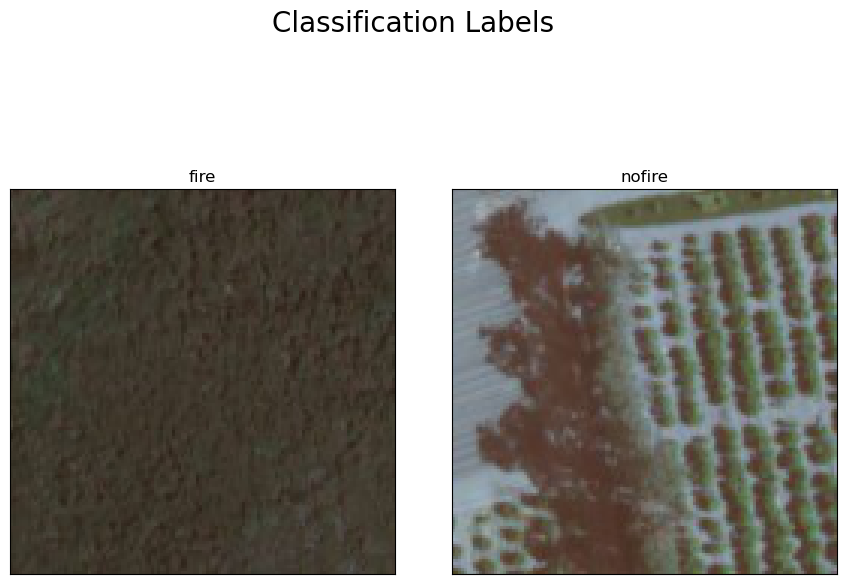

In [42]:
# Grab a batch of images from our validation generator: 
x, y = validation_generator.next() 

# Our images labels are one-hot encoded, lets 
# convert them to ordinal encoding
labels = np.argmax(y, axis=1)

landscape_classes = ['fire','nofire']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 14))
ax = ax.flatten()

for i in range(2):
    index = np.argmax(labels==i) 
    ax[i].imshow(x[index])
    
    # Set the title of the subplot
    ax[i].set_title(landscape_classes[i])
    
    # Hide the x and y ticks
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])
    

fig.suptitle("Classification Labels", size = 20)
fig.tight_layout()

# Delete the two unused subplots
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])

plt.show()

#### Run `VGG19` model

In [18]:
# compile VGG19 model
# adapted from
# https://github.com/ZeeTsing/Dogs_breed_classification/blob/master/3_inceptionres_best.ipynb
import tensorflow as tf

adam = tf.keras.optimizers.Adam(learning_rate=0.1)

num_classes=2

res_model.compile(optimizer = adam, 
              loss = 'binary_crossentropy', 
              metrics=['accuracy'])

res_model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 500,
    verbose = True,
    callbacks = [early_stopping])

Epoch 1/500
271/271 [==============================] - 612s 2s/step - loss: 0.1226 - accuracy: 0.9605 - val_loss: 0.3147 - val_accuracy: 0.9305
Epoch 2/500
271/271 [==============================] - 673s 2s/step - loss: 0.1219 - accuracy: 0.9617 - val_loss: 0.7431 - val_accuracy: 0.8078
Epoch 3/500
271/271 [==============================] - 644s 2s/step - loss: 0.0991 - accuracy: 0.9664 - val_loss: 0.5141 - val_accuracy: 0.9016
Epoch 4/500
271/271 [==============================] - 636s 2s/step - loss: 0.0864 - accuracy: 0.9709 - val_loss: 0.3500 - val_accuracy: 0.9165
Epoch 5/500
271/271 [==============================] - 675s 2s/step - loss: 0.0730 - accuracy: 0.9748 - val_loss: 0.4188 - val_accuracy: 0.9272


#### Evaluate 'VGG19' model

In [54]:
# flow control
counter=0
if counter==1:
    score = res_model.evaluate(validation_data, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    counter=1

##### Calculate the predictions

In [ ]:
predict_probas = model.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

##### Convert test labels from one-hot encoding to label encoding

In [56]:
y_test_labels = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test_labels, y_predict)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (8,6))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            xticklabels=landscape_classes,
            yticklabels=landscape_classes,
            cmap="rocket_r",
            linewidths=1,
            
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

NameError: name 'y_test' is not defined

##### Incorrectly predicted images

In [55]:
import math

incorrect_photos = y_test_labels != y_predict

num_images = np.count_nonzero(incorrect_photos)
columns = 3
rows = math.ceil(num_images / columns)

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(10, 3.5*rows))

axes = axes.flatten()

for i, image in enumerate(X_test[incorrect_photos]):
    axes[i].imshow(image, cmap='gray')

    # get predicted label
    predicted_label = landscape_classes[y_predict[incorrect_photos][i]]
    
    # get actual label
    true_label =  landscape_classes[y_test_labels[incorrect_photos][i]]
    
    # set the title of the subplot
    axes[i].set_title(f"Predicted: {predicted_label}\n True: {true_label}")
    
    # Hide the x and y ticks to make 
    axes[i].set_xticks([]) 
    axes[i].set_yticks([])
    
fig.tight_layout()

# Hide unused subplots
for i in range(num_images, rows*columns):
    fig.delaxes(axes[i])

plt.show()

NameError: name 'y_test_labels' is not defined

### `ResNet50v2`